# **LTFS Data Science FinHack 2**

## **Problem statement**

LTFS receives a lot of requests for its various finance offerings that include housing loan, two-wheeler loan, real estate financing and micro loans. The number of applications received is something that varies a lot with season. Going through these applications is a manual process and is tedious. Accurately forecasting the number of cases received can help with resource and manpower management resulting into quick response on applications and more efficient processing.

We have been appointed with the task of forecasting daily cases for **next 3 months for 2 different business segments** at the **country level** keeping in consideration the following major Indian festivals (inclusive but not exhaustive list): Diwali, Dussehra, Ganesh Chaturthi, Navratri, Holi etc. (We are free to use any publicly available open source external datasets). Some other examples could be:

 + Weather
 + Macroeconomic variables

we also note that the external dataset must belong to a reliable source.

## **Data Dictionary**

The train data has been provided in the following way:

 + For business segment 1, historical data has been made available at branch ID level
 + For business segment 2, historical data has been made available at State level.
 

## **Train File**

|Variable|	Definition|
|:------:|:----------:|
|application_date|Date of application|
|application_date|	Date of application|
|segment|	Business Segment (1/2)|
|branch_id|	Anonymised id for branch at which application was received|
|state|	State in which application was received (Karnataka, MP etc.)|
|zone|	Zone of state in which application was received (Central, East etc.)|
|case_count|	(Target) Number of cases/applications received|

## **Test File**

Forecasting needs to be done at country level for the dates provided in test set for each segment.

|Variable|	Definition|
|:------:|:----------:|
|id|	Unique id for each sample in test set|
|application_date|	Date of application|
| segment|	Business Segment (1/2)|

## **Evaluation**

**Evaluation Metric**

The evaluation metric for scoring the forecasts is MAPE (Mean Absolute Percentage Error) M with the formula:

$$M = \frac{100}{n}\sum_{t = 1}^{n}|\frac{A_t - F_t}{A_t}|$$
 
Where $A_t$ is the actual value and $F_t$ is the forecast value.


The Final score is calculated using $MAPE$ for both the segments using the formula:

$Final Score = 0.5*MAPE_{Segment1} + 0.5*MAPE_{Segment2}$


## **Getting started**

### **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### **Reading data**

In [2]:
# Setting the path
import os
path = "E:/Data Science/LTFS-Data-Science-FinHack-2"
os.chdir(path)

In [3]:
# Importing the dataset
train = pd.read_csv("./Input/train_fwYjLYX.csv")
test = pd.read_csv("./Input/test_1eLl9Yf.csv")
Sample_submission = pd.read_csv("./Input/sample_submission_IIzFVsf.csv")

## **Data Preprocessing**

In [4]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.00,WEST BENGAL,EAST,40.00
1,2017-04-03,1,1.00,WEST BENGAL,EAST,5.00
2,2017-04-04,1,1.00,WEST BENGAL,EAST,4.00
3,2017-04-05,1,1.00,WEST BENGAL,EAST,113.00
4,2017-04-07,1,1.00,WEST BENGAL,EAST,76.00


In [5]:
# Data preprocessing function
train_v2 = pd.DataFrame(train.groupby(['application_date', 'segment'])['case_count'].sum()).reset_index()
train_v2.head()

,application_date,segment,case_count
0,2017-04-01,1,299.00
1,2017-04-01,2,897.00
2,2017-04-02,2,605.00
3,2017-04-03,1,42.00
4,2017-04-03,2,2016.00


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


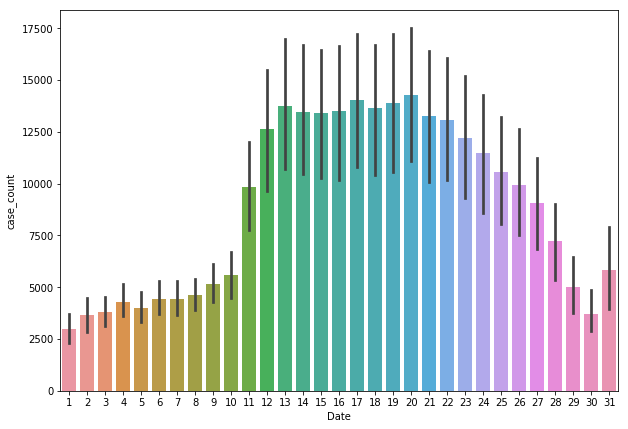

In [6]:
temp = train_v2.copy()
temp['application_date'] = pd.to_datetime(temp['application_date'])
temp['year'] = temp['application_date'].dt.year
temp['Month'] = temp['application_date'].dt.month
temp['Date'] = temp['application_date'].dt.day
temp.head()

plt.figure(figsize = (10, 7))
sns.barplot(x = 'Date', y = 'case_count', data = temp)
plt.show();

## **Feature engineering**

In [7]:
def feature_eng(train_v2):
    train_v2['application_date'] = pd.to_datetime(train_v2['application_date'])
    train_v2['year'] = train_v2['application_date'].dt.year
    train_v2['Month'] = train_v2['application_date'].dt.month
    train_v2['Date'] = train_v2['application_date'].dt.day
    train_v2['weekday'] = train_v2['application_date'].dt.weekday_name

    Weekend = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0,
               'Saturday': 1, 'Sunday': 1}

    Seasons = {6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon', 9: 'Monsoon',
               10: 'Winter', 11: 'Winter', 12: 'Winter', 1: 'Winter',
               2: 'Summer', 3: 'Summer', 4: 'Summer', 5: 'Summer'}

    train_v2['is_weekend'] = train_v2['weekday'].map(Weekend)
    train_v2['Seasons'] = train_v2['Month'].map(Seasons)
    train_v2['lean_period'] = np.where(train_v2['Date'] < 11, 1,
                                       np.where(train_v2['Date'] > 26, 1, 0))

    train_v2['segment'] = np.where(train_v2['segment'] == 1, 1, 0)

    # dummy_col = ['weekday', 'Seasons']
    # temp = train_v2[dummy_col]
    # temp = pd.get_dummies(temp)

    # train_v2 = train_v2.drop(dummy_col, axis = 1)
    # train_v2 = pd.concat([train_v2, temp], axis = 1)

    train_v2 = train_v2.drop(['application_date'], axis = 1)
  
    return train_v2

## **Machine Learning**

### **Creating X and y**

In [8]:
X = train_v2.drop(['case_count'], axis = 1)
y = np.log(train_v2['case_count'])

X = feature_eng(X)

print("Shape of features :", X.shape)
print("Shape of labels :", y.shape)

X.head()

Shape of features : (1650, 8)
Shape of labels : (1650,)


,segment,year,Month,Date,weekday,is_weekend,Seasons,lean_period
0,1,2017,4,1,Saturday,1,Summer,1
1,0,2017,4,1,Saturday,1,Summer,1
2,0,2017,4,2,Sunday,1,Summer,1
3,1,2017,4,3,Monday,0,Summer,1
4,0,2017,4,3,Monday,0,Summer,1


### **Splitting data into train, validation and test**

In [9]:
# Dividing data into train and validation set
from sklearn.model_selection import train_test_split

validation_percent = 0.30
test_percent = 0.50
seed = 786

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = validation_percent, random_state = seed)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size = test_percent, random_state = seed)

# Shape of data
print("Number of rows and columns in train dataset:",X_train.shape)
print("Number of rows and columns in validation dataset:",X_validation.shape)
print("Number of rows and columns in test dataset:",X_test.shape)

print("Number of rows and columns in target variable for training:",y_train.shape)
print("Number of rows and columns in target variable for validation:",y_validation.shape)
print("Number of rows and columns in target variable for test:",y_test.shape)

Number of rows and columns in train dataset: (1155, 8)
Number of rows and columns in validation dataset: (247, 8)
Number of rows and columns in test dataset: (248, 8)
Number of rows and columns in target variable for training: (1155,)
Number of rows and columns in target variable for validation: (247,)
Number of rows and columns in target variable for test: (248,)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

num_var = ['segment', 'year', 'Month', 'Date', 'is_weekend', 'lean_period']
cat_var = ['weekday', 'Seasons']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median'))
    #,('StandardScaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('ordinalencoder', OrdinalEncoder())
])

full_pipeline = ColumnTransformer(transformers = [
    ('numeric', num_pipeline, num_var),
    ('category', cat_pipeline, cat_var)
])

In [11]:
X_train = full_pipeline.fit_transform(X_train)
X_validation = full_pipeline.transform(X_validation)
X_test = full_pipeline.transform(X_test)

print("Number of rows and columns in train dataset:",X_train.shape)
print("Number of rows and columns in validation dataset:",X_validation.shape)
print("Number of rows and columns in test dataset:",X_test.shape)

Number of rows and columns in train dataset: (1155, 8)
Number of rows and columns in validation dataset: (247, 8)
Number of rows and columns in test dataset: (248, 8)


### **Model evualuation**

In [12]:
import sklearn.metrics as sklm
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge,  PassiveAggressiveRegressor, Perceptron, ElasticNet, LassoLars, BayesianRidge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestCentroid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor 
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [13]:
def mape(y_true, y_pred):
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  return mape

In [14]:
def accuracy_summary(Regressor, x_train, y_train, x_validation, y_validation):
    t0 = time()
    model = Regressor.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    train_test_time = time() - t0
    #accuracy = r2_score(y_validation, y_pred)
    accuracy = mape(y_validation, y_pred)
    return accuracy, train_test_time

In [15]:
seed = 123
names = ["Linear Regression", "Lasso","Ridge", "ElasticNet", "LassoLars", "BayesianRidge",
         "HuberRegressor","SGDRegressor", "Linear SVR", 
         "Support Vector Machine with RBF kernel","Passive-Aggresive","KNeighborsRegressor",
         "DecisionTreeRegressor","RandomForestRegressor","AdaBoostRegressor", 
         "GradientBoostingRegressor", "XGBRegressor-linear", "XGBRegressor-Poisson",
         "XGBRegressor-Gamma", "XGBRegressor-Tweedie"]

Regressors = [
    LinearRegression(),
    Lasso(random_state=seed),
    Ridge(random_state=seed),
    ElasticNet(random_state=seed),
    LassoLars(),
    BayesianRidge(),
    HuberRegressor(),
    SGDRegressor(random_state=seed),
    LinearSVR(random_state=seed),
    SVR(),
    PassiveAggressiveRegressor(random_state=seed),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=seed),
    RandomForestRegressor(random_state=seed, n_estimators=500),
    AdaBoostRegressor(random_state=seed, n_estimators=500),
    GradientBoostingRegressor(loss = 'huber', random_state=seed, n_estimators=500),
    XGBRegressor(n_estimators=500, random_state=seed),
    XGBRegressor(n_estimators=500, random_state=seed, objective='count:poisson'),
    XGBRegressor(n_estimators=500, random_state=seed, objective='reg:gamma'),
    XGBRegressor(n_estimators=500, random_state=seed, objective='reg:tweedie')
    ]

zipped_reg = zip(names,Regressors)

def Regressor_comparator(Regressor=zipped_reg):
    result = []
    for n,c in Regressor:
        checker_pipeline = Pipeline([
            ('Regressor', c)
        ])
        print("Validation result for {}".format(n))
        print (c)
        reg_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n,reg_accuracy,tt_time))
    return result

In [16]:
Regression_result = Regressor_comparator()
Regression_result

Validation result for Linear Regression
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Validation result for Lasso
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)
Validation result for Ridge
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)
Validation result for ElasticNet
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=123, selection='cyclic', tol=0.0001, warm_start=False)
Validation result for LassoLars
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)
Validation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Validation result for Support Vector Machine with RBF kernel
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
Validation result for Passive-Aggresive
PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
Validation result for KNeighborsRegressor
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
Validation result for DecisionTreeRegressor
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features

[('Linear Regression', 10.026919931932207, 1.3835475444793701),
 ('Lasso', 15.777142146560802, 0.17913603782653809),
 ('Ridge', 10.029242783241527, 0.31770801544189453),
 ('ElasticNet', 15.788235444360888, 0.001998424530029297),
 ('LassoLars', 15.94849101193076, 0.06895780563354492),
 ('BayesianRidge', 10.030093908042016, 0.13906049728393555),
 ('HuberRegressor', 10.749504067935161, 0.13091278076171875),
 ('SGDRegressor', 6307660174840593.0, 0.036977291107177734),
 ('Linear SVR', 33.35350918723841, 0.17198967933654785),
 ('Support Vector Machine with RBF kernel',
  10.00764542988625,
  0.1855921745300293),
 ('Passive-Aggresive', 17.485279253931008, 0.001999378204345703),
 ('KNeighborsRegressor', 14.626509011255267, 0.04697108268737793),
 ('DecisionTreeRegressor', 7.799173525216334, 0.0356903076171875),
 ('RandomForestRegressor', 5.09994581532501, 2.1027026176452637),
 ('AdaBoostRegressor', 8.850015178346851, 0.20940518379211426),
 ('GradientBoostingRegressor', 6.797004555653767, 1.8413

In [17]:
Regression_result_df = pd.DataFrame(Regression_result)
Regression_result_df.columns = ['Regressor', 'MAPE', 'Train and test time']
Regression_result_df = Regression_result_df.sort_values(by='MAPE', ascending=True)
Regression_result_df['MAPE'] = Regression_result_df['MAPE'].round(1).astype(str) + '%'
Regression_result_df

,Regressor,MAPE,Train and test time
13,RandomForestRegressor,5.1%,2.10
15,GradientBoostingRegressor,6.8%,1.84
16,XGBRegressor-linear,7.0%,0.54
17,XGBRegressor-Poisson,7.3%,0.42
19,XGBRegressor-Tweedie,7.5%,0.50
12,DecisionTreeRegressor,7.8%,0.04
18,XGBRegressor-Gamma,7.9%,0.42
14,AdaBoostRegressor,8.9%,0.21
9,Support Vector Machine with RBF kernel,10.0%,0.19
0,Linear Regression,10.0%,1.38


### **Tuning Randomforest model**

#### **Baseline Model**

In [18]:
import math
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    MAPE = mape(y_true, y_predicted)
    # r2_adj = r2 - (y_true.shape[0] - 1)/(y_true.shape[0] - n_parameters - 1) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('MAPE                    = ' + str(MAPE))

In [19]:
RF_baseline = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

RF_baseline = RF_baseline.fit(X_train, y_train)
y_predict_validation = RF_baseline.predict(X_validation)

# Accuracy on validation data
print_metrics(y_validation, y_predict_validation)

Mean Square Error      = 0.27373878189306994
Root Mean Square Error = 0.5232005178639161
Mean Absolute Error    = 0.28253901930465586
Median Absolute Error  = 0.1382396223813629
R^2                    = 0.8512033658283022
MAPE                    = 5.09994581532501


In [20]:
import sklearn.model_selection as ms
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
import numpy.random as nr
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

nr.seed(498)
scoring = 'r2'
#custom_scorer = make_scorer(mape, greater_is_better=False)
cv_estimate = ms.cross_val_score(RF_baseline, X_train, y_train, 
                                 cv = outside,  scoring = scoring) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.742
SDT of the metric       = 0.051
Outcomes by cv fold
Fold  1    0.723
Fold  2    0.709
Fold  3    0.741
Fold  4    0.853
Fold  5    0.713
Fold  6    0.697
Fold  7    0.770
Fold  8    0.811
Fold  9    0.691
Fold 10    0.709


#### **Hyperparameter tuning**

##### **No of Trees**

In [21]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
# Number of trees in random forest
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

#param_grid = {"n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
param_grid = {'n_estimators': n_estimators}
#print(param_grid)

nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_baseline, param_grid = param_grid,scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'n_estimators': 100}


##### **Max Features**

In [28]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": [1,2,3,4,5,6,7,8]}

RF_2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_2, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'max_features': 5}


##### **Max_depth**

In [29]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_depth": [10,20,30,40,50,60,70,80,90,100, None]}

RF_3 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_3, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'max_depth': 30}


##### **Min Sample split**

In [30]:

nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10]}

RF_4 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_4, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'min_samples_split': 6}


##### **min_samples_leaf**

In [31]:

nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"min_samples_leaf": [1, 2, 3, 4, 5]}

RF_5 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_5, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'min_samples_leaf': 3}


##### **Bootstrap**

In [32]:

nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"bootstrap": [True, False]}

RF_6 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_6, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'bootstrap': True}


##### **Criterian**

In [33]:
nr.seed(786)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"criterion": ['mse', 'mae']}

RF_7 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = RF_7, param_grid = param_grid, scoring = scoring, 
                      cv = inside, # Use the inside folds
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(X_train, y_train)

## And print the best parameter value
print(clf.best_params_)

{'criterion': 'mse'}


#### **Tuned RandomForest**

In [34]:
outside = ms.KFold(n_splits=10, shuffle = True)

nr.seed(498)
scoring = 'r2'
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False) 

model = model.fit(X_train, y_train)
y_predict_validation = model.predict(X_validation)

# Accuracy on validation data
print_metrics(y_validation, y_predict_validation)
print(" ")
print("Cross validation result")
#custom_scorer = make_scorer(mape, greater_is_better=False)
cv_estimate = ms.cross_val_score(model, X_train, y_train, 
                                 cv = outside,  scoring = scoring) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean Square Error      = 0.34599169707424676
Root Mean Square Error = 0.588210589053144
Mean Absolute Error    = 0.3186791552075097
Median Absolute Error  = 0.15875159171015873
R^2                    = 0.8119287313987098
MAPE                    = 6.210711663571468
 
Cross validation result
Mean performance metric = 0.764
SDT of the metric       = 0.055
Outcomes by cv fold
Fold  1    0.723
Fold  2    0.772
Fold  3    0.764
Fold  4    0.873
Fold  5    0.800
Fold  6    0.683
Fold  7    0.793
Fold  8    0.813
Fold  9    0.711
Fold 10    0.707


### **Final Score**

In [35]:
y_predict_test = model.predict(X_test)

# Accuracy on validation data
print_metrics(y_test, y_predict_test)

Mean Square Error      = 0.5954506787094186
Root Mean Square Error = 0.7716545073473092
Mean Absolute Error    = 0.36292597527882686
Median Absolute Error  = 0.16414738845143173
R^2                    = 0.7142320177019772
MAPE                    = 7.993487594125913


## **Predicting test data**

In [36]:
test_v2 = test.drop(['id'], axis = 1)
test_v2 = feature_eng(test_v2)

print("Shape of features :", test_v2.shape)

Shape of features : (180, 8)


In [37]:
feature_list = X.columns.tolist()
dummy_add = list(set(feature_list) - set(test_v2.columns))

for newcol in dummy_add:
    test_v2[newcol] = 0

test_v2 = test_v2[feature_list]

test_v2.head()

,segment,year,Month,Date,weekday,is_weekend,Seasons,lean_period
0,1,2019,7,6,Saturday,1,Monsoon,1
1,1,2019,7,7,Sunday,1,Monsoon,1
2,1,2019,7,8,Monday,0,Monsoon,1
3,1,2019,7,9,Tuesday,0,Monsoon,1
4,1,2019,7,10,Wednesday,0,Monsoon,1


In [38]:
test_v2 = full_pipeline.transform(test_v2)

print("Number of rows and columns in test dataset:",test_v2.shape)

Number of rows and columns in test dataset: (180, 8)


In [39]:
test['case_count'] = np.exp(model.predict(test_v2))
test['case_count'] = test['case_count'].round(0)
test.head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,1863.00
1,2,2019-07-07,1,1540.00
2,3,2019-07-08,1,3009.00
3,4,2019-07-09,1,3234.00
4,5,2019-07-10,1,3341.00


In [40]:
Submission = test[['id', 'application_date', 'segment', 'case_count']]

Submission.to_csv("./Output/Submission_v5.csv", index = False)